## Var name setting

In [1]:
subjectID='9'
noEpochs=1000
noLSTMUnits=100

# Change to true if input file 's features are sorted by time (False by default) 
orderedInput=True

# Change at least one of these 2 variable to true for reading inputFeatures (Can be both)
fourInputFeats=True
onlyVel=False

HRInputFeats=False
assert onlyVel==True or fourInputFeats == True or HRInputFeats==True, "Both condition are false!! Need at least one of these 2 variables to true"

# Change number of steps according to Matlab file for testing input data
test_noTimeSteps=50 

# Change to 1 if want to export to CSV O2 precict against test (0 by default)
exportCSV=1

# Chabge to 1 if want to save the training model (0 by default)
savedModel=1

# Set seed value for uniform (NOT RECOMMEND TO CHANGE, by default 12321)
seed_value = 11

# Getting input file name
if orderedInput:
    orderedPrefix = 'order-'
    sortedPrefix = '_sored'
    fileName='inputFeatures'+subjectID+'_sorted.mat'
else:    
    # Unordered input features
    orderedPrefix = ''
    sortedPrefix = ''
    fileName='inputFeatures'+subjectID+'.mat'

## For testinng purpose
#fileName="inputFeatures29_sorted.mat"
#fileName='inputFeatures9_sorted_99.mat'
print("Input file: ",fileName)

Input file:  inputFeatures9_sorted.mat


## Include lib

In [2]:
from keras.models import load_model
import scipy.io as sio 
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib
from datetime import datetime as dt
from keras import backend as K
from keras.callbacks import EarlyStopping

#from comet_ml import Experiment

## Set seed for training

In [3]:
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Defilne parser function

In [4]:
list_test=[]

"""
The function take number of feature according to data 
and return a list normalized input features data
"""
def parse_input(noFeatures):
    global list_test
    print("Number of features: ",noFeatures)
    if noFeatures==5:
        print("Keep all data")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData)
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData)
    elif noFeatures==4:
        print("Remove HR data")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData[:,:4])
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData[:,:4])
    elif noFeatures==1 and onlyVel==1:
        print("Only vel feature")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData[:,[1]])
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData[:,[1]])
    elif noFeatures==1 and onlyVel==0:
        print("Only HR data")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData[:,[-1]])
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData[:,[-11]])
    else:
        # Code will runinto this part
        print("Unknown number of features")
        
    print("---------")
    print(np.shape(list_test))    
    list_test=np.vstack(list_test)
    print(np.shape(list_test))
    scaler = StandardScaler()
    scaler=scaler.fit(list_test)
    scaled_list_test=scaler.transform(list_test)
    
    return scaled_list_test

## Read input from Matlab file

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

i=sio.loadmat(fileName)

TTest=i['TTest']
TTrain=i['TTrain']
XTrain=i['XTrain']
XTest=i['XTest']

XTrain=XTrain.reshape(-1)
TTrain=TTrain.reshape(-1)
XTest=XTest.reshape(-1)
TTest=TTest.reshape(-1)

test=np.transpose(XTrain).reshape(-1)
test2=np.transpose(XTest).reshape(-1)

print(np.shape(test[0]))
print(np.shape(test2[0]))

# Get number of features and number of number of time steps
#noFeatures = np.shape(test[0])[0]
noTimeSteps = np.shape(test[0])[1]
#print(noFeatures)

# Validate the input data's number of feature and number of time step
assert noTimeSteps == test_noTimeSteps, "The number of time steps does not match our configuration!! Check either of them"
print("The time step now should be ",noTimeSteps)

if fourInputFeats and HRInputFeats:
    #assert noFeatures==5, "The number of input features is not 5! Check setting again"
    print("5 input features included: speed, speedChange, stepDuration, vertOscillation_dist_amp, heart rate")
    confPrefix="withHR_"
    noFeatures=5
elif fourInputFeats:
    #assert noFeatures==4, "The number of input features is not 4! Check setting again"
    print("4 input features included: speed, speedChange, stepDuration, vertOscillation_dist_amp")
    confPrefix="NoHR_"
    noFeatures=4
elif HRInputFeats:
    print("1 input feture included: heart rate")
    confPrefix="onlyHR_"
elif onlyVel:
    #assert noFeatures==1, "The number of input features is not 1! Check setting again"
    print("1 input feture included: speed")
    confPrefix="onlyVel_"
    noFeatures=1
else:
    ## Both conditions are false, code will not run into this section
    print("Both condition are false!! Need at least ")
    
# Automatically setting name of output files based on configuration    
modelSaveName=confPrefix+'Subj-'+subjectID+'-'+str(noEpochs)+'pochs-'+orderedPrefix+str(noLSTMUnits)+'-LSTM_u.h5'
figPredictName=confPrefix+'Subj'+subjectID+'-'+str(noEpochs)+'pochs-'+orderedPrefix+str(noLSTMUnits)+'-LSTM_u.jpg'
figRMSEName=confPrefix+'RMSE_Subj'+subjectID+'-'+str(noEpochs)+'pochs-'+orderedPrefix+str(noLSTMUnits)+'-LSTM_u.jpg'

(5, 50)
(5, 50)
The time step now should be  50
4 input features included: speed, speedChange, stepDuration, vertOscillation_dist_amp


## Call parser function

In [6]:
scaled_list_test = parse_input(noFeatures)

# Return back input data with scaled value
XT_s_stack=list()
i=0
timeSteps=noTimeSteps
while i+timeSteps <= (len(scaled_list_test)):
    XT_s_stack.append(scaled_list_test[i:i+timeSteps])
    i=i+timeSteps

XT_s_stack=np.stack(XT_s_stack)
cutPoint=np.shape(TTest.reshape(-1))[0]


XTrain_s=XT_s_stack[:-cutPoint,:,:]
XTest_s=XT_s_stack[-cutPoint:,:,:]

Number of features:  4
Remove HR data
---------
(1344, 50, 4)
(67200, 4)


## Configure the model

In [7]:
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=20)

In [8]:
length = noTimeSteps
n_features = noFeatures
model = Sequential()
model.add(LSTM(noLSTMUnits,input_shape=(length,n_features)))
model.add(Dense(1))
opt=Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='mean_squared_logarithmic_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________


## Training

In [9]:
#print(np.shape(XTrain_s))
#print(np.isnan(XTrain_s))
#print(XTrain_s)

In [10]:
# print(np.shape(TTrain))
# TTrain[np.isnan(TTrain)]=0
# print(TTrain)

In [11]:
#TTrain[np.isnan(TTrain)]=0
with tf.device('/gpu:0'):
    start = dt.now()
    hist=model.fit(XTrain_s,np.array(TTrain),epochs=noEpochs,verbose=2)
    trainTime=(dt.now() - start)

Epoch 1/1000
34/34 - 5s - loss: 3.5084 - 5s/epoch - 150ms/step
Epoch 2/1000
34/34 - 1s - loss: 1.9469 - 1s/epoch - 33ms/step
Epoch 3/1000
34/34 - 1s - loss: 0.3968 - 1s/epoch - 34ms/step
Epoch 4/1000
34/34 - 1s - loss: 0.2216 - 1s/epoch - 36ms/step
Epoch 5/1000
34/34 - 1s - loss: 0.2209 - 1s/epoch - 37ms/step
Epoch 6/1000
34/34 - 1s - loss: 0.2205 - 1s/epoch - 36ms/step
Epoch 7/1000
34/34 - 1s - loss: 0.2199 - 1s/epoch - 34ms/step
Epoch 8/1000
34/34 - 1s - loss: 0.2188 - 1s/epoch - 33ms/step
Epoch 9/1000
34/34 - 1s - loss: 0.2177 - 1s/epoch - 34ms/step
Epoch 10/1000
34/34 - 1s - loss: 0.2142 - 1s/epoch - 37ms/step
Epoch 11/1000
34/34 - 1s - loss: 0.2081 - 1s/epoch - 36ms/step
Epoch 12/1000
34/34 - 1s - loss: 0.1960 - 1s/epoch - 33ms/step
Epoch 13/1000
34/34 - 1s - loss: 0.1812 - 1s/epoch - 39ms/step
Epoch 14/1000
34/34 - 1s - loss: 0.1563 - 1s/epoch - 37ms/step
Epoch 15/1000
34/34 - 1s - loss: 0.1412 - 1s/epoch - 35ms/step
Epoch 16/1000
34/34 - 1s - loss: 0.1134 - 1s/epoch - 35ms/step


Epoch 131/1000
34/34 - 1s - loss: 0.0524 - 1s/epoch - 35ms/step
Epoch 132/1000
34/34 - 1s - loss: 0.0496 - 1s/epoch - 34ms/step
Epoch 133/1000
34/34 - 1s - loss: 0.0486 - 1s/epoch - 35ms/step
Epoch 134/1000
34/34 - 1s - loss: 0.0491 - 1s/epoch - 34ms/step
Epoch 135/1000
34/34 - 1s - loss: 0.0517 - 1s/epoch - 34ms/step
Epoch 136/1000
34/34 - 1s - loss: 0.0561 - 1s/epoch - 35ms/step
Epoch 137/1000
34/34 - 1s - loss: 0.0474 - 1s/epoch - 35ms/step
Epoch 138/1000
34/34 - 1s - loss: 0.0448 - 1s/epoch - 35ms/step
Epoch 139/1000
34/34 - 1s - loss: 0.0462 - 1s/epoch - 35ms/step
Epoch 140/1000
34/34 - 1s - loss: 0.0466 - 1s/epoch - 33ms/step
Epoch 141/1000
34/34 - 1s - loss: 0.0591 - 1s/epoch - 33ms/step
Epoch 142/1000
34/34 - 1s - loss: 0.0624 - 1s/epoch - 34ms/step
Epoch 143/1000
34/34 - 1s - loss: 0.0576 - 1s/epoch - 35ms/step
Epoch 144/1000
34/34 - 1s - loss: 0.0501 - 1s/epoch - 34ms/step
Epoch 145/1000
34/34 - 1s - loss: 0.0528 - 1s/epoch - 36ms/step
Epoch 146/1000
34/34 - 1s - loss: 0.0482

34/34 - 1s - loss: 0.0184 - 1s/epoch - 35ms/step
Epoch 260/1000
34/34 - 1s - loss: 0.0208 - 1s/epoch - 35ms/step
Epoch 261/1000
34/34 - 1s - loss: 0.0234 - 1s/epoch - 35ms/step
Epoch 262/1000
34/34 - 1s - loss: 0.0208 - 1s/epoch - 35ms/step
Epoch 263/1000
34/34 - 1s - loss: 0.0150 - 1s/epoch - 34ms/step
Epoch 264/1000
34/34 - 1s - loss: 0.0152 - 1s/epoch - 34ms/step
Epoch 265/1000
34/34 - 1s - loss: 0.0120 - 1s/epoch - 34ms/step
Epoch 266/1000
34/34 - 1s - loss: 0.0121 - 1s/epoch - 33ms/step
Epoch 267/1000
34/34 - 1s - loss: 0.0111 - 1s/epoch - 36ms/step
Epoch 268/1000
34/34 - 1s - loss: 0.0110 - 1s/epoch - 35ms/step
Epoch 269/1000
34/34 - 1s - loss: 0.0153 - 1s/epoch - 35ms/step
Epoch 270/1000
34/34 - 1s - loss: 0.0118 - 1s/epoch - 36ms/step
Epoch 271/1000
34/34 - 1s - loss: 0.0127 - 1s/epoch - 35ms/step
Epoch 272/1000
34/34 - 1s - loss: 0.0110 - 1s/epoch - 36ms/step
Epoch 273/1000
34/34 - 1s - loss: 0.0124 - 1s/epoch - 35ms/step
Epoch 274/1000
34/34 - 1s - loss: 0.0092 - 1s/epoch - 3

Epoch 388/1000
34/34 - 1s - loss: 0.0020 - 1s/epoch - 37ms/step
Epoch 389/1000
34/34 - 2s - loss: 0.0020 - 2s/epoch - 45ms/step
Epoch 390/1000
34/34 - 2s - loss: 0.0018 - 2s/epoch - 52ms/step
Epoch 391/1000
34/34 - 1s - loss: 0.0023 - 1s/epoch - 41ms/step
Epoch 392/1000
34/34 - 2s - loss: 0.0022 - 2s/epoch - 49ms/step
Epoch 393/1000
34/34 - 1s - loss: 0.0025 - 1s/epoch - 44ms/step
Epoch 394/1000
34/34 - 1s - loss: 0.0020 - 1s/epoch - 44ms/step
Epoch 395/1000
34/34 - 1s - loss: 0.0015 - 1s/epoch - 43ms/step
Epoch 396/1000
34/34 - 2s - loss: 0.0015 - 2s/epoch - 46ms/step
Epoch 397/1000
34/34 - 2s - loss: 0.0013 - 2s/epoch - 45ms/step
Epoch 398/1000
34/34 - 1s - loss: 0.0014 - 1s/epoch - 39ms/step
Epoch 399/1000
34/34 - 1s - loss: 0.0111 - 1s/epoch - 39ms/step
Epoch 400/1000
34/34 - 1s - loss: 0.0075 - 1s/epoch - 39ms/step
Epoch 401/1000
34/34 - 1s - loss: 0.0060 - 1s/epoch - 37ms/step
Epoch 402/1000
34/34 - 1s - loss: 0.0072 - 1s/epoch - 39ms/step
Epoch 403/1000
34/34 - 1s - loss: 0.0093

34/34 - 1s - loss: 0.0052 - 1s/epoch - 41ms/step
Epoch 515/1000
34/34 - 1s - loss: 0.0068 - 1s/epoch - 37ms/step
Epoch 516/1000
34/34 - 1s - loss: 0.0076 - 1s/epoch - 40ms/step
Epoch 517/1000
34/34 - 1s - loss: 0.0127 - 1s/epoch - 40ms/step
Epoch 518/1000
34/34 - 1s - loss: 0.0063 - 1s/epoch - 37ms/step
Epoch 519/1000
34/34 - 1s - loss: 0.0052 - 1s/epoch - 40ms/step
Epoch 520/1000
34/34 - 1s - loss: 0.0041 - 1s/epoch - 39ms/step
Epoch 521/1000
34/34 - 1s - loss: 0.0036 - 1s/epoch - 38ms/step
Epoch 522/1000
34/34 - 1s - loss: 0.0033 - 1s/epoch - 36ms/step
Epoch 523/1000
34/34 - 1s - loss: 0.0028 - 1s/epoch - 36ms/step
Epoch 524/1000
34/34 - 1s - loss: 0.0030 - 1s/epoch - 42ms/step
Epoch 525/1000
34/34 - 1s - loss: 0.0037 - 1s/epoch - 38ms/step
Epoch 526/1000
34/34 - 1s - loss: 0.0035 - 1s/epoch - 38ms/step
Epoch 527/1000
34/34 - 1s - loss: 0.0033 - 1s/epoch - 37ms/step
Epoch 528/1000
34/34 - 1s - loss: 0.0038 - 1s/epoch - 40ms/step
Epoch 529/1000
34/34 - 1s - loss: 0.0035 - 1s/epoch - 3

Epoch 640/1000
34/34 - 1s - loss: 2.3368e-04 - 1s/epoch - 42ms/step
Epoch 641/1000
34/34 - 1s - loss: 6.9443e-04 - 1s/epoch - 44ms/step
Epoch 642/1000
34/34 - 1s - loss: 0.0015 - 1s/epoch - 43ms/step
Epoch 643/1000
34/34 - 1s - loss: 9.0693e-04 - 1s/epoch - 38ms/step
Epoch 644/1000
34/34 - 1s - loss: 0.0010 - 1s/epoch - 36ms/step
Epoch 645/1000
34/34 - 1s - loss: 6.4405e-04 - 1s/epoch - 37ms/step
Epoch 646/1000
34/34 - 1s - loss: 0.0113 - 1s/epoch - 37ms/step
Epoch 647/1000
34/34 - 1s - loss: 0.0089 - 1s/epoch - 37ms/step
Epoch 648/1000
34/34 - 1s - loss: 0.0100 - 1s/epoch - 38ms/step
Epoch 649/1000
34/34 - 1s - loss: 0.0110 - 1s/epoch - 42ms/step
Epoch 650/1000
34/34 - 1s - loss: 0.0131 - 1s/epoch - 43ms/step
Epoch 651/1000
34/34 - 1s - loss: 0.0074 - 1s/epoch - 37ms/step
Epoch 652/1000
34/34 - 1s - loss: 0.0058 - 1s/epoch - 37ms/step
Epoch 653/1000
34/34 - 1s - loss: 0.0021 - 1s/epoch - 37ms/step
Epoch 654/1000
34/34 - 1s - loss: 0.0033 - 1s/epoch - 35ms/step
Epoch 655/1000
34/34 - 1

Epoch 763/1000
34/34 - 1s - loss: 3.0109e-04 - 1s/epoch - 36ms/step
Epoch 764/1000
34/34 - 1s - loss: 2.2678e-04 - 1s/epoch - 35ms/step
Epoch 765/1000
34/34 - 1s - loss: 2.0043e-04 - 1s/epoch - 35ms/step
Epoch 766/1000
34/34 - 1s - loss: 1.8521e-04 - 1s/epoch - 36ms/step
Epoch 767/1000
34/34 - 1s - loss: 1.7107e-04 - 1s/epoch - 35ms/step
Epoch 768/1000
34/34 - 1s - loss: 1.6460e-04 - 1s/epoch - 36ms/step
Epoch 769/1000
34/34 - 1s - loss: 1.6658e-04 - 1s/epoch - 34ms/step
Epoch 770/1000
34/34 - 1s - loss: 1.7437e-04 - 1s/epoch - 35ms/step
Epoch 771/1000
34/34 - 1s - loss: 1.5733e-04 - 1s/epoch - 35ms/step
Epoch 772/1000
34/34 - 1s - loss: 1.6574e-04 - 1s/epoch - 34ms/step
Epoch 773/1000
34/34 - 1s - loss: 1.6833e-04 - 1s/epoch - 34ms/step
Epoch 774/1000
34/34 - 1s - loss: 1.7065e-04 - 1s/epoch - 36ms/step
Epoch 775/1000
34/34 - 1s - loss: 1.7992e-04 - 1s/epoch - 36ms/step
Epoch 776/1000
34/34 - 1s - loss: 1.8943e-04 - 1s/epoch - 35ms/step
Epoch 777/1000
34/34 - 1s - loss: 1.8321e-04 - 1

34/34 - 1s - loss: 1.1265e-04 - 1s/epoch - 36ms/step
Epoch 885/1000
34/34 - 1s - loss: 1.2040e-04 - 1s/epoch - 35ms/step
Epoch 886/1000
34/34 - 1s - loss: 1.1921e-04 - 1s/epoch - 36ms/step
Epoch 887/1000
34/34 - 1s - loss: 1.2845e-04 - 1s/epoch - 37ms/step
Epoch 888/1000
34/34 - 1s - loss: 1.3036e-04 - 1s/epoch - 36ms/step
Epoch 889/1000
34/34 - 1s - loss: 1.3215e-04 - 1s/epoch - 37ms/step
Epoch 890/1000
34/34 - 1s - loss: 1.2351e-04 - 1s/epoch - 35ms/step
Epoch 891/1000
34/34 - 1s - loss: 1.0923e-04 - 1s/epoch - 35ms/step
Epoch 892/1000
34/34 - 1s - loss: 1.1352e-04 - 1s/epoch - 34ms/step
Epoch 893/1000
34/34 - 1s - loss: 1.0530e-04 - 1s/epoch - 35ms/step
Epoch 894/1000
34/34 - 1s - loss: 1.0400e-04 - 1s/epoch - 35ms/step
Epoch 895/1000
34/34 - 1s - loss: 1.2588e-04 - 1s/epoch - 36ms/step
Epoch 896/1000
34/34 - 1s - loss: 1.2694e-04 - 1s/epoch - 35ms/step
Epoch 897/1000
34/34 - 1s - loss: 1.0613e-04 - 1s/epoch - 35ms/step
Epoch 898/1000
34/34 - 1s - loss: 1.2705e-04 - 1s/epoch - 35ms/

In [12]:
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# plt.figure(figsize=(35,15))
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epochs')
# plt.legend(['train', 'validation'], loc='upper right',prop={'size': 10})
# fig = plt.gcf()
# plt.yscale("log")
# fig.set_size_inches(20.5, 10.5)
# plt.show()

In [13]:
print("Train time: ",trainTime,"s")

Train time:  0:20:38.225338 s


## Inference

In [14]:
with tf.device('/cpu:0'):
    startInf = dt.now()
    Y_hat=model.predict(XTest_s)
    inferenceTime=(dt.now() - startInf)


9/9 [==============================] - 0s 9ms/step


In [15]:
print("Inference time: ",inferenceTime,"s")

Inference time:  0:00:00.484836 s


In [16]:
print(XTrain_s.shape)
print(TTrain.shape)

(1075, 50, 4)
(1075,)


## Plot prediction 

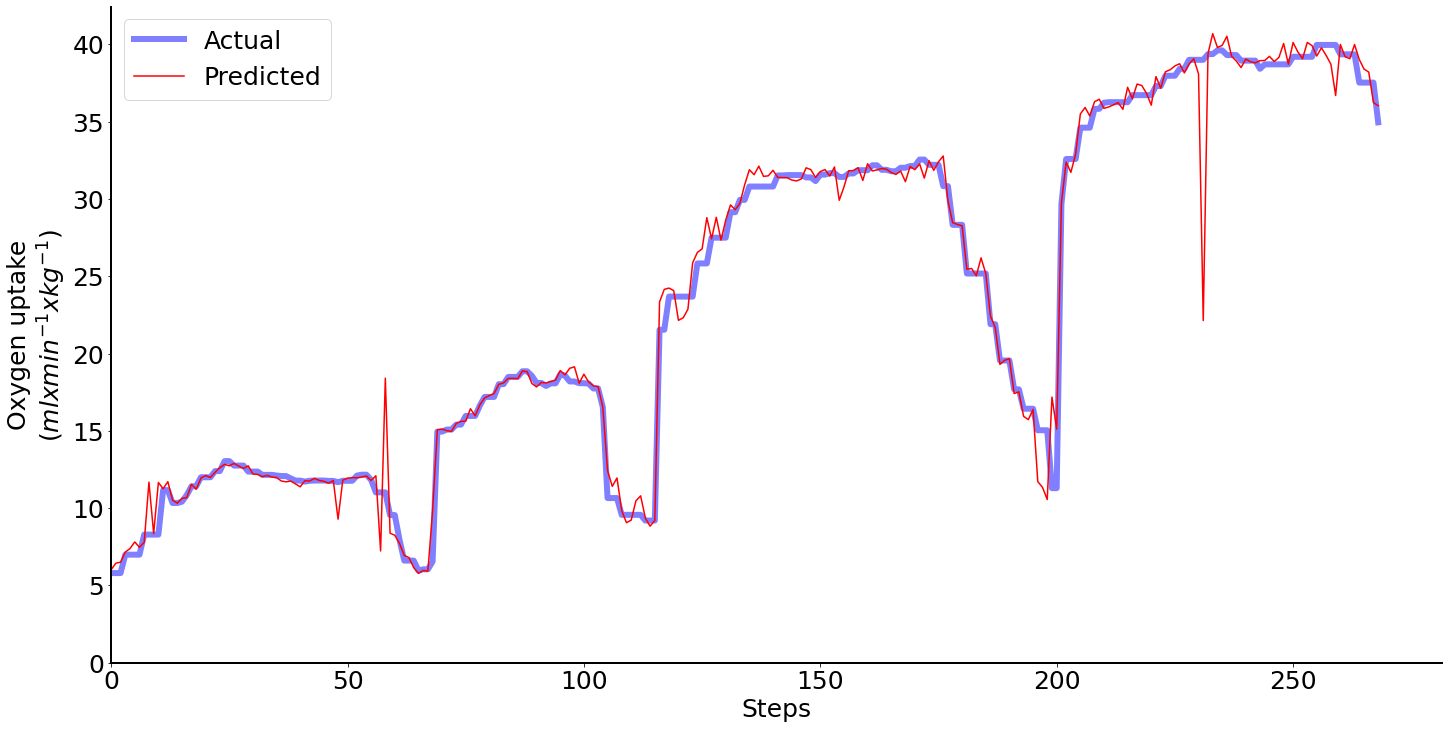

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.figure(figsize=(15,7))
plt.plot(TTest,color='blue',label='Actual',alpha=0.5,linewidth=6.0)
plt.plot(Y_hat,color='red',label='Predicted')
plt.xlabel('Steps',fontsize=25,backgroundcolor='w')
plt.ylabel("Oxygen uptake\n"+"$(mlxmin^{-1}xkg^{-1})$",fontsize=25,backgroundcolor='w')
plt.tight_layout()

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)

plt.ylim(0)
plt.xlim(0)

plt.legend(prop={'size': 25},loc='upper left')
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
plt.savefig(figPredictName)
plt.show()

## Save model

In [18]:
if savedModel:
    model.save(modelSaveName)

In [19]:
print(np.shape(Y_hat))
print(np.shape(TTest))
#Y_hat=np.expand_dims(Y_hat,axis=0)
#TTest=np.expand_dims(TTest,axis=0)
#print(np.shape(XTrain_s))
#print(np.shape(TTrain))
results = model.evaluate(XTest_s,TTest)

(269, 1)
(269,)
9/9 [==============================] - 0s 8ms/step - loss: 0.0065


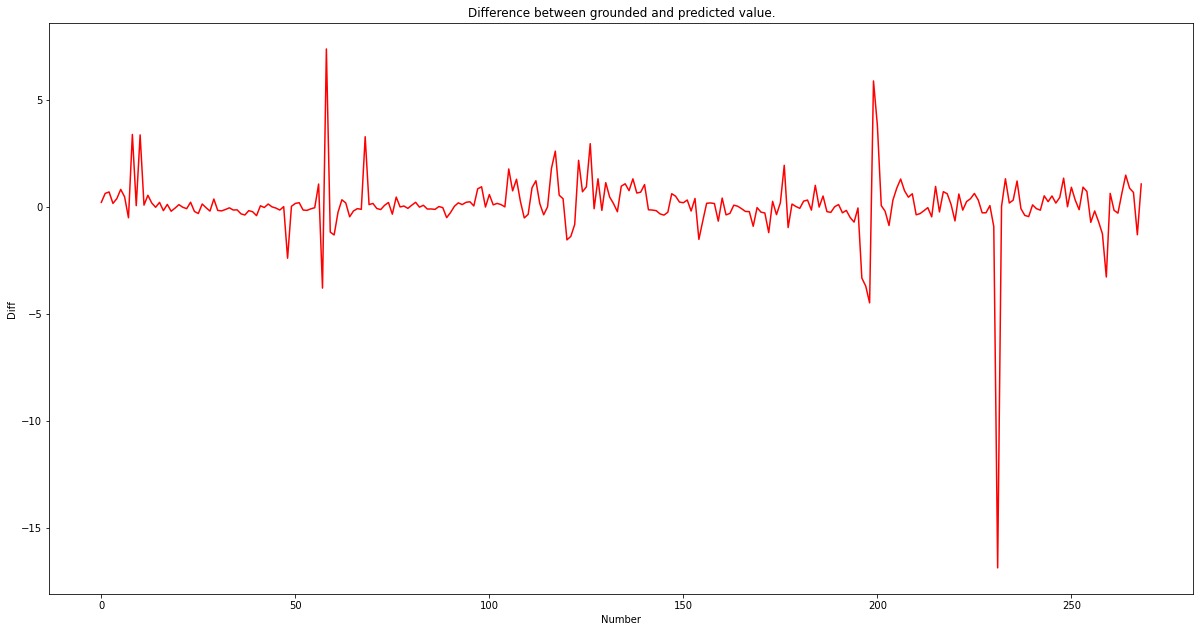

In [20]:
#Y_hat=np.transpose(Y_hat)
TTest=TTest.reshape(len(TTest),1)
#print(Y_hat)
#diff=np.concatenate((Y_hat,TTest),axis=1)
diff=np.subtract(Y_hat,TTest)
#print(diff)
plt.figure(figsize=(20.5,15.5))
plt.plot(diff,color='red')
plt.xlabel('Number')
plt.ylabel('Diff')
plt.title('Difference between grounded and predicted value.')
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
#fig.savefig(figPredictName+'L_'+str(results)+'.jpg', dpi=150)
plt.show()
#model.save('1st-stage-subj-1.h5')

In [21]:
rmse=np.sqrt(np.square(np.subtract(TTest,Y_hat)).mean())
print("RMSE Error: ",rmse)

RMSE Error:  1.4942832558198134


In [22]:
res=np.concatenate((Y_hat,TTest,Y_hat-TTest,(Y_hat+TTest)/2),axis=1)
print(res)

if exportCSV:
    if HRInputFeats and fourInputFeats:
        pd.DataFrame(res).to_csv('Subj-'+subjectID+'-predict-wHR.csv')
    elif HRInputFeats:        
        pd.DataFrame(res).to_csv('Subj-'+subjectID+'-predict-oHR.csv')
    elif fourInputFeats:
        pd.DataFrame(res).to_csv('Subj-'+subjectID+'-predict-noHR.csv')
    elif onlyVel:
        print("Store to oVel")
        pd.DataFrame(res).to_csv('Subj-'+subjectID+'-predict-oVel.csv')

[[ 6.02222919  5.8028      0.21942919  5.9125146 ]
 [ 6.43925953  5.8028      0.63645953  6.12102976]
 [ 6.50778103  5.8028      0.70498103  6.15529051]
 ...
 [38.206604   37.526       0.680604   37.866302  ]
 [36.2293663  37.526      -1.2966337  36.87768315]
 [36.03376389 34.956       1.07776389 35.49488194]]
